# Curve with `xarray`

In [3]:
import lasio

In [4]:
l = lasio.read('P-129_out.LAS')

## Class definition

In [5]:
# -*- coding: utf 8 -*-
"""
Python installation file.
"""
import xarray as xr
import numpy as np

class CurveError(Exception):
    pass

class Curve(object):

    def __init__(self, data, basis=None, basis_kind='MD', params=None):
        """Seismic data object based on xarray.DataArray.
        
        Args:
            data (Array): np.ndarray of the log curve.
        """
        self.start = params.get('start', 0)
        self.step = params.get('step', 1)
        self.mnemonic = params.get('mnemonic', None)
        self.units = params.get('units', None)
        self.run = params.get('run', 0)
        self.null = params.get('null', -999.25)
        self.service_company = params.get('service_company', None)
        self.date = params.get('date', None)
        self.code = params.get('code', None)

        self._xarray = xr.DataArray(data, coords=[basis], dims=[basis_kind], name=self.mnemonic)
        return
        
    def __getattr__(self, attr):
        """
        Passes methods through to the xarray.DataArray object.
        """
        if attr in self.__dict__:
            return getattr(self, attr)
        return getattr(self._xarray, attr)
    
    def __getitem__(self, item):
        """
        Get items with keys.
        """
        # Deal with string key.
        return self._xarray.__getitem__(item)

#         # Deal with slice key.
#         if isinstance(item, slice):
#             return self._xarray._getitem_coord(item)

#         # Preserve coordinates.
#         cp = list(self._xarray.coords.items())  # parent coordinates
#         coords = [(cp[i]) for i, it in enumerate(item) if not type(it) == int]
#         return Curve(self._xarray[item].data, coords=coords)

    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result
    
    def describe(self):
        """
        Return basic statistics about the curve.
        """
        stats = {}
        stats['samples'] = self.shape[0]
        stats['nulls'] = self[np.isnan(self)].shape[0]
        stats['mean'] = float(np.nanmean(self.real))
        stats['min'] = float(np.nanmin(self.real))
        stats['max'] = float(np.nanmax(self.real))
        return stats

    get_stats = describe



    def _repr_html_(self):
        """
        Jupyter Notebook magic repr function.
        """
        if self.size < 10:
            return np.ndarray.__repr__(self)
        attribs = self.__dict__.copy()

        # Header.
        row1 = '<tr><th style="text-align:center;" colspan="2">{} [{{}}]</th></tr>'
        rows = row1.format(attribs.pop('mnemonic'))
        rows = rows.format(attribs.pop('units', '&ndash;'))
        row2 = '<tr><td style="text-align:center;" colspan="2">{:.4f} : {:.4f} : {:.4f}</td></tr>'
        rows += row2.format(attribs.pop('start'), self.stop, attribs.pop('step'))

        # Curve attributes.
        s = '<tr><td><strong>{k}</strong></td><td>{v}</td></tr>'
        for k, v in attribs.items():
            rows += s.format(k=k, v=v)

        # Curve stats.
        rows += '<tr><th style="border-top: 2px solid #000; text-align:center;" colspan="2"><strong>Stats</strong></th></tr>'
        stats = self.get_stats()
        s = '<tr><td><strong>samples (NaNs)</strong></td><td>{samples} ({nulls})</td></tr>'
        s += '<tr><td><strong><sub>min</sub> mean <sup>max</sup></strong></td>'
        s += '<td><sub>{min:.2f}</sub> {mean:.3f} <sup>{max:.2f}</sup></td></tr>'
        rows += s.format(**stats)

        # Curve preview.
        s = '<tr><th style="border-top: 2px solid #000;">Depth</th><th style="border-top: 2px solid #000;">Value</th></tr>'
        rows += s.format(self.start, self[0])
        s = '<tr><td>{:.4f}</td><td>{:.4f}</td></tr>'
        for depth, value in zip(self.basis[:3], self[:3]):
            rows += s.format(depth, value)
        rows += '<tr><td>⋮</td><td>⋮</td></tr>'
        for depth, value in zip(self.basis[-3:], self[-3:]):
            rows += s.format(depth, value)

        # Footer.
        # ...

        # End.
        html = '<table>{}</table>'.format(rows)
        return html

#     @property
#     def values(self):
#         return np.array(self)

    @property
    def basis(self):
        return self.coords['MD'].values

    @property
    def stop(self):
        """
        The stop depth. Computed on the fly from the start,
        the step, and the length of the curve.
        """
        return self.start + (self.shape[0] - 1) * self.step

    def describe(self):
        """
        Return basic statistics about the curve.
        """
        stats = {}
        stats['samples'] = self.shape[0]
        stats['nulls'] = self[np.isnan(self)].shape[0]
        stats['mean'] = float(np.nanmean(self.real))
        stats['min'] = float(np.nanmin(self.real))
        stats['max'] = float(np.nanmax(self.real))
        return stats

    def get_alias(self, alias):
        """
        Given a mnemonic, get the alias name(s) it falls under. If there aren't
        any, you get an empty list.
        """
        alias = alias or {}
        return [k for k, v in alias.items() if self.mnemonic in v]


def from_las():
    """
    Instantiate a Curve object from a SEG-Y file.
    """

def from_lasio_curve(curve,
                        depth=None,
                        basis=None,
                        start=None,
                        stop=None,
                        step=0.1524,
                        run=-1,
                        null=-999.25,
                        service_company=None,
                        date=None):
    """
    Makes a curve object from a lasio curve object and either a depth
    basis or start and step information.

    Args:
        curve (ndarray)
        depth (ndarray)
        basis (ndarray)
        start (float)
        stop (float)
        step (float): default: 0.1524
        run (int): default: -1
        null (float): default: -999.25
        service_company (str): Optional.
        data (str): Optional.

    Returns:
        Curve. An instance of the class.
    """
    data = curve.data
    unit = curve.unit

    step = basis[1] - basis[0]
    start = basis[0]

    params = {}
    params['mnemonic'] = curve.mnemonic
    params['description'] = curve.descr
    params['start'] = start
    params['step'] = step
    params['units'] = unit
    params['run'] = run
    params['null'] = null
    params['service_company'] = service_company
    params['date'] = date
    params['code'] = curve.API_code

    return Curve(data, basis, params=params)



/home/matt/anaconda3/envs/geocomp/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [6]:
c = from_lasio_curve(l.curves.DT, basis=l.curves.DEPT.data)

In [7]:
c

TypeError: unsupported format string passed to DataArray.__format__

In [8]:
c[2000:2010]  # positional index

<xarray.DataArray 'DT' (MD: 10)>
array([71.822784, 71.935768, 71.879082, 72.145882, 70.829315, 69.989731,
       69.617439, 69.929512, 70.101883, 72.229424])
Coordinates:
  * MD       (MD) float64 305.9 306.0 306.2 306.3 ... 306.8 306.9 307.1 307.2

In [10]:
c.loc[304.987:306.345]  # Does interpolation

<xarray.DataArray 'DT' (MD: 9)>
array([76.461975, 76.667618, 74.755836, 74.241592, 72.87252 , 71.822784,
       71.935768, 71.879082, 72.145882])
Coordinates:
  * MD       (MD) float64 305.1 305.3 305.4 305.6 305.7 305.9 306.0 306.2 306.3

In [34]:
c.interp(MD=306, method='linear')

<xarray.DataArray 'DT' ()>
array(71.921534)
Coordinates:
    MD       int64 306

In [35]:
mds = [305, 306, 307]

c.interp(MD=mds, method='linear')

<xarray.DataArray 'DT' (MD: 3)>
array([76.061959, 71.921534, 70.004613])
Coordinates:
  * MD       (MD) int64 305 306 307

See also http://xarray.pydata.org/en/stable/interpolation.html

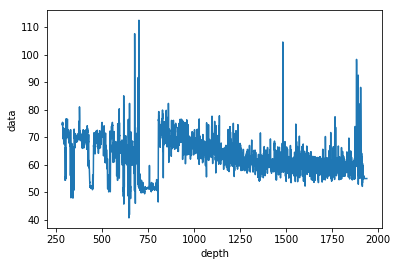

In [92]:
%matplotlib inline

c.plot()